In [276]:
import numpy as np
def loadFile(fileName):
  with open(fileName, 'r') as f:
    filedata = f.read()
    return filedata

# Split data into packets
def parseData(file, transmitterIDs, angleOffset, timeOffset):
    splitFile = file[54:].split('\n\n')
    splitFile = splitFile[1:len(splitFile)-1]
    data = []
    for i in range(len(splitFile)):
      if(len(splitFile[i]) == 29) and splitFile[i][27:28] in transmitterIDs:
        dataPoint = []
        dataPoint.append(-int(splitFile[i][7:9])) # RSSI
        dataPoint.append(splitFile[i][27:28]) # ID
        dataPoint.append(int(int(splitFile[i][23:25] + splitFile[i][26:27], 16))) # Angle (need to normalise between 0 and 359 degrees)
        dataPoint.append(int(splitFile[i][14:16] + splitFile[i][17:19] + splitFile[i][20:22], 16)) # Relative time (not used in this notebook)
        data.append(dataPoint)

    # Standardize the angles
    maximum = max([x[2] for x in data])
    minimum = min([x[2] for x in data])
    for x in range(len(data)):
      data[x][2] = 359 *  ((data[x][2] - minimum) / (maximum-minimum))

    for x in range(len(data)):
      data[x][2] = np.deg2rad((data[x][2] + angleOffset) % (maximum+1))

    return data
file = loadFile("no rf amp experiments/noamploc2long.log")
transmitterProfile = parseData(file, ['d','e','f'], 246, 0)

In [277]:
transmitterProfile

[[-78, 'e', 2.181661564992912, 747899],
 [-86, 'f', 2.199114857512855, 747900],
 [-84, 'd', 2.2165681500327987, 747685],
 [-78, 'e', 2.181661564992912, 747899],
 [-84, 'd', 2.2165681500327987, 747685],
 [-75, 'e', 2.234021442552742, 747914],
 [-79, 'd', 2.2689280275926285, 747700],
 [-75, 'e', 2.234021442552742, 747914],
 [-80, 'd', 2.2689280275926285, 747700],
 [-76, 'e', 2.2863813201125716, 747929],
 [-83, 'd', 2.321287905152458, 747714],
 [-75, 'e', 2.2863813201125716, 747929],
 [-81, 'd', 2.356194490192345, 747727],
 [-82, 'd', 2.356194490192345, 747727],
 [-76, 'e', 2.321287905152458, 747942],
 [-76, 'e', 2.3736477827122884, 747957],
 [-78, 'd', 2.4085543677521746, 747742],
 [-84, 'f', 2.3911010752322315, 747964],
 [-79, 'e', 2.426007660272118, 747972],
 [-81, 'd', 2.443460952792061, 747756],
 [-79, 'e', 2.426007660272118, 747972],
 [-81, 'd', 2.443460952792061, 747756],
 [-81, 'f', 2.443460952792061, 747976],
 [-84, 'f', 2.5132741228718345, 748002],
 [-74, 'e', 2.5132741228718345

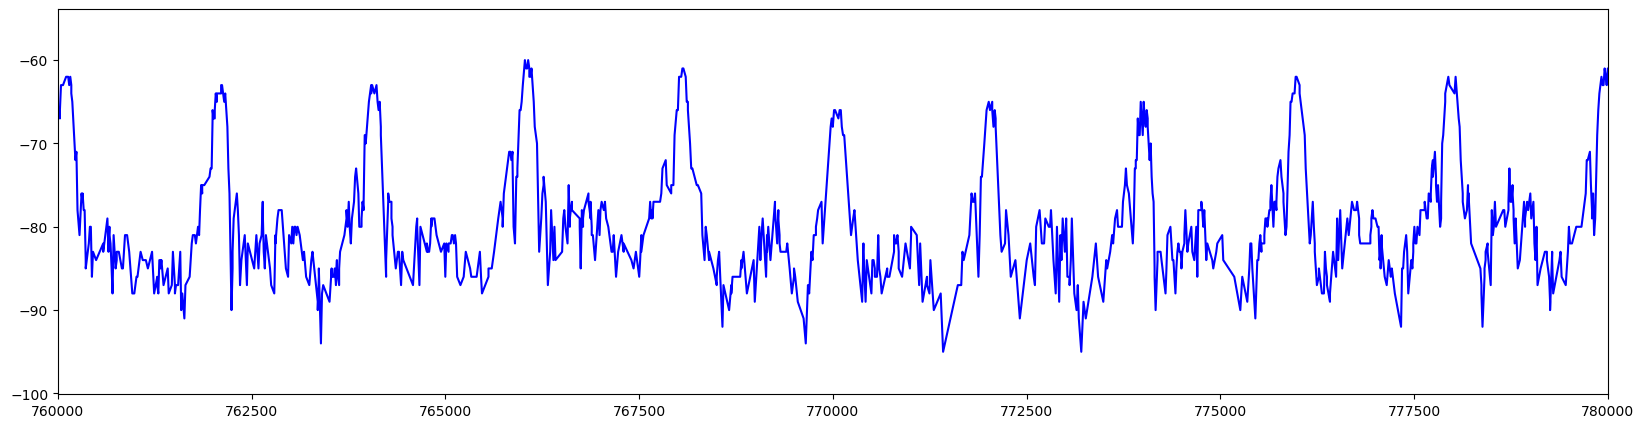

In [278]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[20,5])
transmitterProfile = np.array(transmitterProfile)
for t,c in zip(['d'],['b-']):
    tp = transmitterProfile[transmitterProfile[:,1]==t,:]
    plt.plot(tp[:,-1].astype(float),tp[:,0].astype(float),c)
    plt.xlim([760000,760000+20000])
    #print(np.min(tp[:,-1].astype(float)))

In [279]:
data = transmitterProfile[transmitterProfile[:,1]=='d'][:,[0,2,3]].astype(float)
data = data[np.argsort(data[:,-1]),:]

In [280]:
getsample(data,623421)

(array([0., 0.]), 2.2165681500327987, array([-84., -84., -84.]))

In [281]:
def getsample(data,time):
    times = np.array([time-300,time-100,time+100,time+300,time])
    idxs = np.argmin(np.abs(data[:,-1:]-times[None,:]),0)
    sigs = data[idxs,0]
    signaldiffs = sigs[:-1]-sigs[-1]
    
    #signaldiffs = np.array([data[idxs[0],0]-data[idxs[1],0],data[idxs[2],0]-data[idxs[1],0]])
    return signaldiffs,np.mean(data[idxs,1]),data[idxs,0]

record = []
mint,maxt = np.min(data[:,-1]),np.max(data[:,-1])
avgss = [1000]*20
for i,t in enumerate(np.arange(mint+100e3,maxt,100)):
    del avgss[:3]
    avgss.extend(list(rawss))
    signalstrengths,angle,rawss = getsample(data,t)
    #if np.mean(rawss)<np.mean(avgss)+3: continue ### IS IT A GOOD IDEA TO REMOVE FROM THE TRAINING SIGNALS THAT <3dB ABOVE AVG??!?
    record.append([t]+list(signalstrengths)+[angle])
    #print(angle)
    if i%1000==0:
        print(t-mint,maxt-mint)

100000.0 733482.0
200000.0 733482.0
300000.0 733482.0
400000.0 733482.0
500000.0 733482.0
600000.0 733482.0
700000.0 733482.0


In [282]:
record = np.array(record)

In [283]:
record

array([[ 8.47685000e+05, -7.00000000e+00, -4.00000000e+00,
         3.00000000e+00,  1.80000000e+01,  2.46091425e+00],
       [ 8.47785000e+05, -8.00000000e+00, -3.00000000e+00,
         1.00000000e+00,  1.50000000e+01,  2.76460154e+00],
       [ 8.47885000e+05, -8.00000000e+00, -1.00000000e+00,
         1.40000000e+01,  4.00000000e+00,  3.08225146e+00],
       ...,
       [ 1.48088500e+06,  1.80000000e+01,  3.00000000e+00,
        -2.00000000e+00,  3.00000000e+00,  4.94277244e+00],
       [ 1.48098500e+06,  1.10000000e+01,  2.00000000e+00,
         6.00000000e+00,  5.00000000e+00,  5.20108117e+00],
       [ 1.48108500e+06, -1.00000000e+00, -6.00000000e+00,
        -1.00000000e+00, -1.00000000e+00,  5.39306739e+00]])

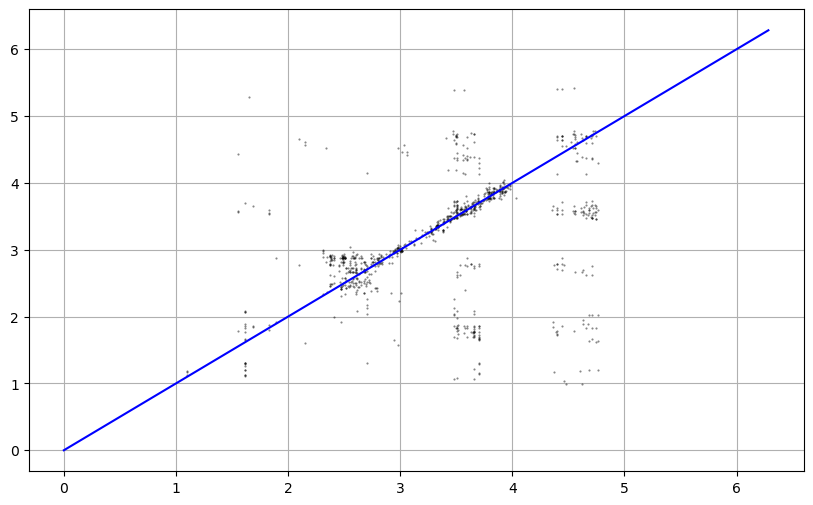

In [314]:
plt.figure(figsize=[10,6])
avgss = [1000]*20
for i,t in enumerate(np.arange(mint+20e3,mint+90e3,30)):    
    ss,ang,rawss = getsample(data,t)
    del avgss[:1]
    #avgss.extend(list(rawss))
    avgss.append(rawss[-1])
    
    predangle = record[np.all(np.abs(ss-record[:,1:-1])<2,1),-1]    
    
    #plt.plot(t,ang,'.b',markersize=1)
    #if np.mean(rawss)<np.mean(avgss)+3: continue
    if np.mean(rawss[-1])<np.mean(avgss)+4: continue
    plt.plot(np.repeat(ang,len(predangle)),predangle,'k.',markersize=1,alpha=0.5)
    #plt.plot(t,(np.mean(ss)+60)/10,'r+')
    
    #plt.plot(np.repeat(t,len(predangle)),predangle,'.k',markersize=3,alpha=0.5)
#plt.ylim([3,4])
#plt.xlim([3,4])
plt.plot([0,np.pi*2],[0,np.pi*2],'b-')
plt.grid()

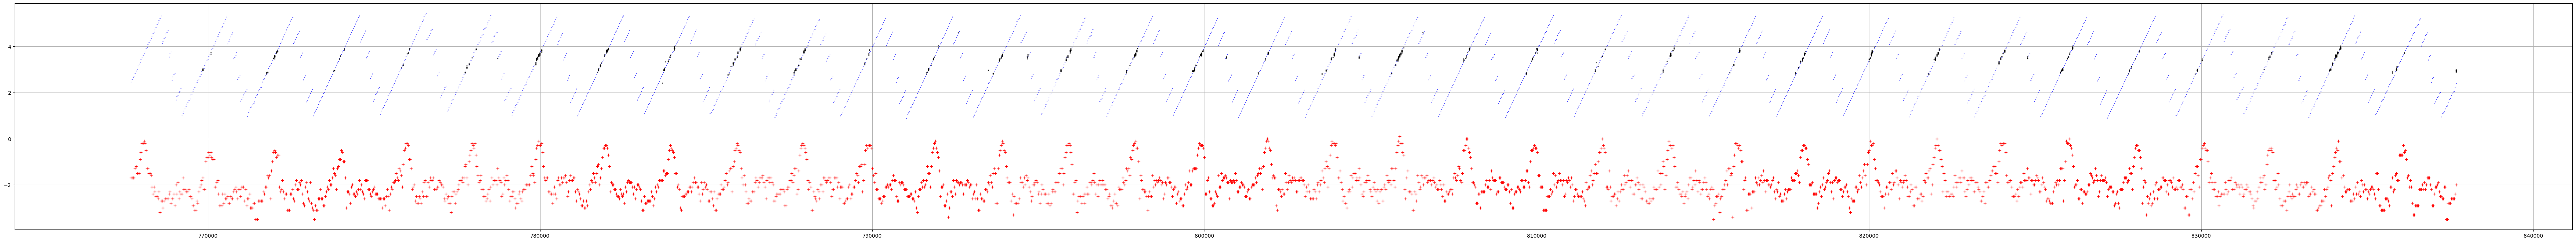

In [317]:
plt.figure(figsize=[90,8])
mae = []
avgss = [1000]*20
for i,t in enumerate(np.arange(mint+20e3,mint+90e3,30)):    
    ss,ang,rawss = getsample(data,t)
    del avgss[:1]
    #avgss.extend(list(rawss))
    avgss.append(rawss[-1])
    
    predangle = record[np.all(np.abs(ss-record[:,1:-1])<3,1),-1]    
    predangle
    plt.plot(t,ang,'.b',markersize=1)
    plt.plot(t,(rawss[-1]+60)/10,'r+')
    
    if np.mean(rawss[-1])<np.mean(avgss)+4: continue
    #if len(predangle)<10: continue
    if (np.std(predangle)>0.04): continue
    plt.plot(np.repeat(t,len(predangle)),predangle,'.k',markersize=3,alpha=0.5)
    mae.append(np.mean(np.abs(predangle-ang)))
#plt.ylim([3,4])
plt.grid()
plt.savefig('a.pdf')

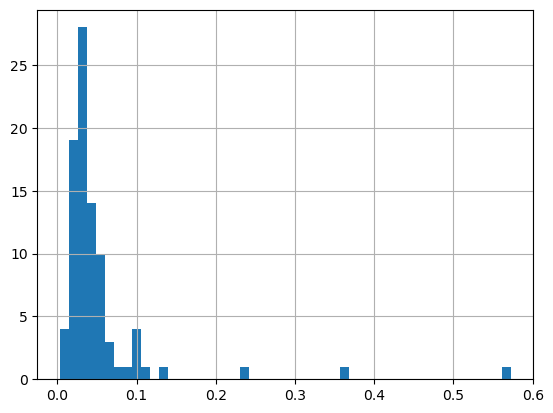

In [311]:
plt.hist(mae,50)#,np.linspace(0,0.1,30))
plt.grid()

In [313]:
np.rad2deg(0.05)

2.8647889756541165

In [127]:
len(avgss)

20

In [29]:
data #rssi, angle, time

array([[-8.40000000e+01,  2.21656815e+00,  7.47685000e+05],
       [-8.40000000e+01,  2.21656815e+00,  7.47685000e+05],
       [-7.90000000e+01,  2.26892803e+00,  7.47700000e+05],
       ...,
       [-8.20000000e+01,  5.44542727e+00,  1.48106200e+06],
       [-8.00000000e+01,  5.58505361e+00,  1.48110700e+06],
       [-8.10000000e+01,  5.77703982e+00,  1.48116700e+06]])

In [27]:
import re
data = []
with open('no rf amp experiments/noamploc2long.log', 'r') as fh:
    for i,line in enumerate(fh):
        
        msg = re.findall('RSSI: ([\-0-9]*) \[([a-f0-9]{2}):([a-f0-9]{2}):([a-f0-9]{2}):([a-f0-9]{2}):([a-f0-9]{2}):([a-f0-9]{2})\]',line)
        if len(msg)>0:
            msg = msg[0]
            rssi = int(msg[0])
            transid = msg[6][1]
            data.append(rssi)
        

In [29]:
transid

'f'

In [28]:
rssi

-81

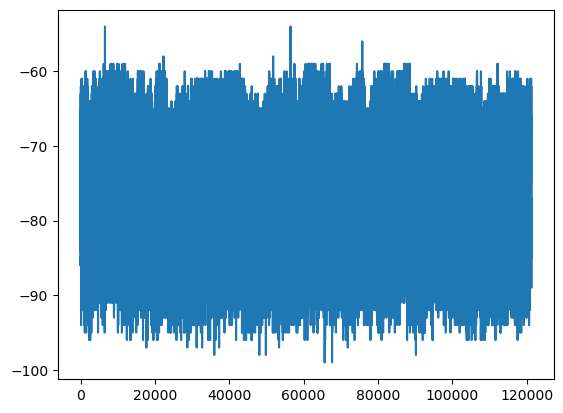

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(data)